In [1]:
import os
import zarr
import timm
import random
import json
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
import sys
import torch

# import torchvision.transforms.functional as F
import random

warnings.filterwarnings("ignore")
sys.path.append("./src/")

from src.config import CFG
from src.dataloader import (
    read_zarr,
    read_info_json,
    scale_coordinates,
    create_dataset,
    create_segmentation_map,
    EziiDataset,
    drop_padding,
)
from src.network import Unet3D
from src.utils import save_images, PadToSize
from src.metric import (
    score,
    create_cls_pos,
    create_cls_pos_sikii,
    create_df,
    SegmentationLoss,
    DiceLoss,
)
from metric import visualize_epoch_results
from src.utils import save_images
from src.metric import score, create_cls_pos, create_cls_pos_sikii, create_df
from src.inference import inference, inference2pos

sample_submission = pd.read_csv("../../inputs/sample_submission.csv")

In [2]:
# padf = PadToSize(CFG.resolution)


# def last_padding(tomogram, slice_size):
#     # tomogram: (tensor)
#     b, d, h, w = tomogram.shape
#     last_padding = slice_size - d % slice_size
#     if last_padding == slice_size:
#         return tomogram
#     else:
#         return torch.cat(
#             [tomogram, torch.zeros(b, last_padding, h, w).to(tomogram.device)], dim=1
#         )


# def preprocess_tensor(tensor):
#     batch_size, depth, height, width = tensor.shape
#     tensor = tensor.unsqueeze(2)  # (b, d, h, w) -> (b, d, 1, h, w)
#     return tensor


# def inference(model, exp_name, train=True):
#     dataset = EziiDataset(
#         exp_names=[exp_name],
#         base_dir="../../inputs/train/",
#         particles_name=CFG.particles_name,
#         resolution=CFG.resolution,
#         zarr_type=["denoised"],
#         train=train,
#         slice=False,
#     )
#     res_array = CFG.original_img_shape[CFG.resolution]
#     pred_array = np.zeros(
#         (len(CFG.particles_name) + 1, res_array[0], res_array[1], res_array[2])
#     )
#     loader = DataLoader(dataset, batch_size=1, shuffle=False, pin_memory=True)
#     model.eval()
#     # tq = tqdm(loader)
#     for data in loader:  # 実験データ1つを取り出す
#         for i in range(0, data["normalized_tomogram"].shape[1], CFG.slice_):
#             normalized_tomogram = data["normalized_tomogram"][:, i : i + CFG.slice_]
#             normalized_tomogram = last_padding(normalized_tomogram, CFG.slice_)
#             normalized_tomogram = padf(normalized_tomogram)
#             normalized_tomogram = preprocess_tensor(normalized_tomogram).to("cuda")
#             pred = model(normalized_tomogram)
#             prob_pred = (
#                 torch.softmax(pred, dim=1).detach().cpu().numpy()
#             )  # torch.Size([1, 7, 32, 320, 320])
#             range_ = min(i + CFG.slice_, res_array[0])
#             hw_pad_diff = prob_pred.shape[-1] - res_array[-1]

#             if i >= res_array[0]:
#                 continue

#             if range_ == res_array[0]:
#                 pred_array[:, i:range_] += prob_pred[
#                     0, :, : res_array[0] - i, :-hw_pad_diff, :-hw_pad_diff
#                 ]
#             else:
#                 pred_array[:, i:range_] += prob_pred[
#                     0, :, :range_, :-hw_pad_diff, :-hw_pad_diff
#                 ]

#         if train:
#             segmentation_map = data["segmentation_map"]
#         else:
#             segmentation_map = None

#         normalized_tomogram = data["normalized_tomogram"]
#     # tq.close()

#     return pred_array, normalized_tomogram, segmentation_map  # (7, 92, 315, 315)


# def inference2pos(pred_segmask, exp_name):
#     import cc3d

#     cls_pos = []
#     Ascale_pos = []
#     res2ratio = CFG.resolution2ratio

#     for pred_cls in range(1, len(CFG.particles_name) + 1):
#         print(pred_cls, CFG.cls2particles[pred_cls])
#         cc, P = cc3d.connected_components(pred_segmask == pred_cls, return_N=True)
#         stats = cc3d.statistics(cc)

#         for z, y, x in stats["centroids"]:
#             Ascale_z = z * res2ratio[CFG.resolution] / res2ratio["A"]
#             Ascale_x = x * res2ratio[CFG.resolution] / res2ratio["A"]
#             Ascale_y = y * res2ratio[CFG.resolution] / res2ratio["A"]

#             cls_pos.append([pred_cls, z, y, x])
#             Ascale_pos.append([pred_cls, Ascale_z, Ascale_y, Ascale_x])

#     pred_original_df = create_df(Ascale_pos, exp_name)

#     return pred_original_df

In [3]:
# train_dataset = EziiDataset(
#     exp_names=CFG.train_exp_names,
#     base_dir="../../inputs/train/",
#     particles_name=CFG.particles_name,
#     resolution=CFG.resolution,
#     zarr_type=CFG.train_zarr_types,
#     train=True,
#     augmentation=False,
#     slice=False,
#     pre_read=True,
# )

# # train_nshuffle_dataset = EziiDataset(
# #     exp_names=CFG.train_exp_names,
# #     base_dir="../../inputs/train/",
# #     particles_name=CFG.particles_name,
# #     resolution=CFG.resolution,
# #     zarr_type=CFG.train_zarr_types,
# #     augmentation=False,
# #     train=True,
# # )

# valid_dataset = EziiDataset(
#     exp_names=CFG.valid_exp_names,
#     base_dir="../../inputs/train/",
#     particles_name=CFG.particles_name,
#     resolution=CFG.resolution,
#     zarr_type=CFG.valid_zarr_types,
#     augmentation=False,
#     train=True,
#     slice=False,
#     pre_read=True,
# )

# from tqdm import tqdm

# train_loader = DataLoader(
#     train_dataset,
#     batch_size=CFG.batch_size,
#     shuffle=True,
#     drop_last=True,
#     pin_memory=True,
#     num_workers=CFG.num_workers,
# )
# # train_nshuffle_loader = DataLoader(
# #     train_nshuffle_dataset,
# #     batch_size=1,
# #     shuffle=True,
# #     drop_last=True,
# #     pin_memory=True,
# #     num_workers=CFG.num_workers,
# # )
# valid_loader = DataLoader(
#     valid_dataset,
#     batch_size=1,
#     shuffle=False,
#     pin_memory=True,
#     num_workers=CFG.num_workers,
# )

# for data in tqdm(train_loader):
#     normalized_tomogram = data["normalized_tomogram"]
#     segmentation_map = data["segmentation_map"]
#     break

# normalized_tomogram.shape

In [4]:
# for data in tqdm(train_loader):
#     exp_names = data["exp_name"]
#     normalized_tomogram = data["normalized_tomogram"]
#     segmentation_map = data["segmentation_map"]
#     break

In [5]:
# exp_names, normalized_tomogram.shape, segmentation_map.shape

In [6]:
# import cc3d

# all_pred = []

# for data in tqdm(train_dataset):
#     exp_name = data["exp_name"]
#     normalized_tomogram = data["normalized_tomogram"]
#     segmentation_map = data["segmentation_map"]
#     # print(segmentation_map.shape)
#     gt = segmentation_map  # .numpy()

#     cls_pos = []
#     Ascale_pos = []
#     res2ratio = CFG.resolution2ratio
#     # exp_name = exp_names[i]

#     for pred_cls in range(1, len(CFG.particles_name) + 1):
#         cc, P = cc3d.connected_components(gt == pred_cls, return_N=True)
#         stats = cc3d.statistics(cc)

#         for z, y, x in stats["centroids"][1:]:
#             Ascale_z = z * res2ratio[CFG.resolution] / res2ratio["A"]
#             Ascale_x = x * res2ratio[CFG.resolution] / res2ratio["A"]
#             Ascale_y = y * res2ratio[CFG.resolution] / res2ratio["A"]

#             cls_pos.append([pred_cls, z, y, x])
#             Ascale_pos.append([pred_cls, Ascale_z, Ascale_y, Ascale_x])

#     pred_original_df = create_df(Ascale_pos, exp_name)
#     all_pred.append(pred_original_df)

# all_pred = pd.concat(all_pred).reset_index().drop_duplicates(subset=["x", "y", "z"])

In [7]:
def create_gt_df(base_dir, exp_names):
    result_df = None
    particle_names = CFG.particles_name

    for exp_name in exp_names:
        for particle in particle_names:
            np_corrds = read_info_json(
                base_dir=base_dir, exp_name=exp_name, particle_name=particle
            )  # (n, 3)
            # 各行にexp_nameとparticle_name追加
            particle_df = pd.DataFrame(np_corrds, columns=["z", "y", "x"])
            particle_df["experiment"] = exp_name
            particle_df["particle_type"] = particle

            if result_df is None:
                result_df = particle_df
            else:
                result_df = pd.concat([result_df, particle_df], axis=0).reset_index(
                    drop=True
                )

    result_df = result_df.reset_index()
    result_df = result_df[["index", "experiment", "particle_type", "x", "y", "z"]]

    return result_df


gt_df = create_gt_df("../../inputs/train/overlay/ExperimentRuns/", CFG.train_exp_names)
gt_df

,index,experiment,particle_type,x,y,z
0,0,TS_4,apo-ferritin,3045.036742,919.139280,421.270403
1,1,TS_4,apo-ferritin,2969.078552,1027.114255,440.085721
2,2,TS_4,apo-ferritin,2839.792769,1069.080767,425.839468
3,3,TS_4,apo-ferritin,2875.180486,1077.907940,298.254286
4,4,TS_4,apo-ferritin,2765.950544,1019.336833,322.072039
...,...,...,...,...,...,...
14400,14400,TS_6_6,virus-like-particle,2609.876000,4569.876000,1169.759000
14401,14401,TS_6_6,virus-like-particle,2213.287000,4135.017000,1286.851000
14402,14402,TS_6_6,virus-like-particle,3303.905000,5697.825000,789.744000
14403,14403,TS_6_6,virus-like-particle,1008.748000,5949.213000,1077.303000


In [8]:
# score(all_pred, gt_df, row_id_column_name="index", distance_multiplier=0.5, beta=4)

In [9]:
# all_pred

In [10]:
encoder = timm.create_model(
    model_name=CFG.model_name,
    pretrained=True,
    in_chans=3,
    num_classes=0,
    global_pool="",
    features_only=True,
)
model = Unet3D(encoder=encoder).to("cuda")
model.load_state_dict(torch.load("./best_model.pth"))

<All keys matched successfully>

In [11]:
# from tqdm import tqdm

# # ############### validation ################
# train_nshuffle_original_tomogram = defaultdict(list)
# train_nshuffle_pred_tomogram = defaultdict(list)
# train_nshuffle_gt_tomogram = defaultdict(list)
# train_cls_pos = defaultdict(list)
# train_cls_Apos = defaultdict(list)

# valid_original_tomogram = defaultdict(list)
# valid_pred_tomogram = defaultdict(list)
# valid_gt_tomogram = defaultdict(list)
# valid_cls_pos = defaultdict(list)
# valid_cls_Apos = defaultdict(list)

# train_mean_scores = []
# valid_mean_scores = []

# # # for exp_name in tqdm(CFG.train_exp_names):
# # for exp_name in tqdm(CFG.train_exp_names[:5]):  # 5つのデータで試す
# #     inferenced_array, n_tomogram, segmentation_map = inference(
# #         model, exp_name, train=True
# #     )
# #     train_nshuffle_pred_tomogram[exp_name] = inferenced_array
# #     train_nshuffle_gt_tomogram[exp_name] = segmentation_map.squeeze(0)
# #     train_nshuffle_original_tomogram[exp_name] = n_tomogram.squeeze(0)

# #     mean_score, scores, pred_df, gt_df, pred_cls_pos, pred_Ascale_pos = (
# #         visualize_epoch_results(
# #             train_nshuffle_pred_tomogram,
# #             base_dir="../../inputs/train/overlay/ExperimentRuns/",
# #             sikii_dict=CFG.initial_sikii,
# #         )
# #     )
# #     train_cls_pos[exp_name] = pred_cls_pos
# #     train_cls_Apos[exp_name] = pred_Ascale_pos
# #     train_mean_scores.append(mean_score)
# # print("train_mean_scores", np.mean(train_mean_scores))

# for exp_name in tqdm(CFG.valid_exp_names):
#     inferenced_array, n_tomogram, segmentation_map = inference(
#         model, exp_name, train=True
#     )
#     valid_pred_tomogram[exp_name] = inferenced_array
#     valid_gt_tomogram[exp_name] = segmentation_map.squeeze(0)
#     valid_original_tomogram[exp_name] = n_tomogram.squeeze(0)

#     mean_score, scores, pred_df, gt_df, pred_cls_pos, pred_Ascale_pos = (
#         visualize_epoch_results(
#             valid_pred_tomogram,
#             base_dir="../../inputs/train/overlay/ExperimentRuns/",
#             sikii_dict=CFG.initial_sikii,
#         )
#     )
#     valid_cls_pos[exp_name] = pred_cls_pos
#     valid_cls_Apos[exp_name] = pred_Ascale_pos
#     valid_mean_scores.append(mean_score)
# print("valid_mean_scores", np.mean(valid_mean_scores))

In [12]:
# inferenced_array, n_tomogram, segmentation_map = inference(model, exp_name, train=True)
# pred_original_df = inference2pos(
#     pred_segmask=inferenced_array,
#     exp_name=exp_name,
#     sikii_dict=CFG.initial_sikii,
# )
# pred_df

In [13]:
def inference2pos(pred_segmask, exp_name, sikii_dict):
    import cc3d

    cls_pos = []
    Ascale_pos = []
    res2ratio = CFG.resolution2ratio

    for pred_cls in range(1, len(CFG.particles_name) + 1):
        sikii = sikii_dict[CFG.cls2particles[pred_cls]]
        # print(pred_segmask[pred_cls].shape)
        cc, P = cc3d.connected_components(pred_segmask[pred_cls] > sikii, return_N=True)
        # cc, P = cc3d.connected_components(pred_segmask == pred_cls, return_N=True)
        stats = cc3d.statistics(cc)

        for z, y, x in stats["centroids"][1:]:
            Ascale_z = z * res2ratio[CFG.resolution] / res2ratio["A"]
            Ascale_x = x * res2ratio[CFG.resolution] / res2ratio["A"]
            Ascale_y = y * res2ratio[CFG.resolution] / res2ratio["A"]

            cls_pos.append([pred_cls, z, y, x])
            Ascale_pos.append([pred_cls, Ascale_z, Ascale_y, Ascale_x])

    pred_original_df = create_df(Ascale_pos, exp_name)

    return pred_original_df

In [14]:
# pred_original_df

In [15]:
# score(pred_df, gt_df, row_id_column_name="index", distance_multiplier=1.0, beta=4)

In [16]:
# pred_df[pred_df["particle_type"] == "apo-ferritin"].sort_values("z")

In [17]:
# gt_df[gt_df["particle_type"] == "apo-ferritin"].sort_values("z")

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

num_classes = len(CFG.particles_name)  # クラス数
colors = plt.cm.tab10(
    np.arange(len(CFG.particles_name))
)  # "tab10" カラーマップから色を取得

# ListedColormap を作成
class_colormap = ListedColormap(colors)


def plot_with_colormap(data, title, original_tomogram):
    masked_data = np.ma.masked_where(data <= 0, data)  # クラス0をマスク
    plt.imshow(original_tomogram, cmap="gray")
    im = plt.imshow(masked_data, cmap=class_colormap)
    plt.title(title)
    plt.axis("off")
    return im


def imshow_result(pred, gt, original, index):
    # plt.figure(figsize=(20, 5))
    ax = plt.subplot(1, 3, 1)
    plot_with_colormap(
        pred[index],
        "Train-Prediction",
        original[index],
    )
    ax = plt.subplot(1, 3, 2)
    plot_with_colormap(gt[index], "Gt", original[index])

    ax = plt.subplot(1, 3, 3)
    plt.imshow(original[index], cmap="gray")
    plt.axis("off")

    plt.show()

In [19]:
# exp_name = "TS_5_4"
# index = 12
# pred = train_nshuffle_pred_tomogram[exp_name].argmax(0)  # (92, 315, 315)
# gt = train_nshuffle_gt_tomogram[exp_name]
# original = train_nshuffle_original_tomogram[exp_name]

# # imshow_result(pred, gt, original, index)

# for i in range(42):
#     imshow_result(pred, gt, original, i)

In [20]:
# exp_name = "TS_5_4"
# index = 12
# pred = train_nshuffle_pred_tomogram[exp_name].argmax(0)  # (92, 315, 315)
# gt = train_nshuffle_gt_tomogram[exp_name]
# original = train_nshuffle_original_tomogram[exp_name]

# # imshow_result(pred, gt, original, index)

# for i in range(42):
#     imshow_result(pred, gt, original, i)

In [21]:
# exp_name = CFG.valid_exp_names[-1]

# pred = valid_pred_tomogram[exp_name].argmax(0)
# gt = valid_gt_tomogram[exp_name]
# original = valid_original_tomogram[exp_name]

# for i in range(42):
#     imshow_result(pred, gt, original, i)

In [22]:
# exp_name = CFG.train_exp_names[-1]

# pred_cls_pos = train_cls_pos[exp_name]

# exp_name, np.array(pred_cls_pos).max(axis=0)

In [23]:
# exp_name = CFG.valid_exp_names[0]

# pred_cls_pos = valid_cls_pos[exp_name]

# np.array(pred_cls_pos).max(axis=0)

In [24]:
gt_df

,index,experiment,particle_type,x,y,z
0,0,TS_4,apo-ferritin,3045.036742,919.139280,421.270403
1,1,TS_4,apo-ferritin,2969.078552,1027.114255,440.085721
2,2,TS_4,apo-ferritin,2839.792769,1069.080767,425.839468
3,3,TS_4,apo-ferritin,2875.180486,1077.907940,298.254286
4,4,TS_4,apo-ferritin,2765.950544,1019.336833,322.072039
...,...,...,...,...,...,...
14400,14400,TS_6_6,virus-like-particle,2609.876000,4569.876000,1169.759000
14401,14401,TS_6_6,virus-like-particle,2213.287000,4135.017000,1286.851000
14402,14402,TS_6_6,virus-like-particle,3303.905000,5697.825000,789.744000
14403,14403,TS_6_6,virus-like-particle,1008.748000,5949.213000,1077.303000


In [25]:
def create_gt_df(base_dir, exp_names):
    result_df = None
    particle_names = CFG.particles_name

    for exp_name in exp_names:
        for particle in particle_names:
            np_corrds = read_info_json(
                base_dir=base_dir, exp_name=exp_name, particle_name=particle
            )  # (n, 3)
            # 各行にexp_nameとparticle_name追加
            particle_df = pd.DataFrame(np_corrds, columns=["z", "y", "x"])
            particle_df["experiment"] = exp_name
            particle_df["particle_type"] = particle

            if result_df is None:
                result_df = particle_df
            else:
                result_df = pd.concat([result_df, particle_df], axis=0).reset_index(
                    drop=True
                )

    result_df = result_df.reset_index()
    result_df = result_df[["index", "experiment", "particle_type", "x", "y", "z"]]

    return result_df

In [26]:
# # exp_name = CFG.valid_exp_names[0]
# # pred = valid_pred_tomogram[exp_name].argmax(0)
# # gt = valid_gt_tomogram[exp_name]
# # original = valid_original_tomogram[exp_name]
# import timm

# encoder = timm.create_model(
#     model_name=CFG.model_name,
#     pretrained=True,
#     in_chans=3,
#     num_classes=0,
#     global_pool="",
#     features_only=True,
# )
# model = Unet3D(encoder=encoder).to("cuda")
# model.load_state_dict(torch.load("./best_model.pth"))

# exp_name = CFG.train_exp_names[2]
# pred = train_nshuffle_pred_tomogram[exp_name].argmax(0)
# gt = train_nshuffle_gt_tomogram[exp_name]
# original = train_nshuffle_original_tomogram[exp_name]

# base_dir = "../../inputs/train/overlay/ExperimentRuns/"
# gt_df = create_gt_df(base_dir=base_dir, exp_names=[exp_name])

# import cc3d

# cls_pos = []
# Ascale_pos = []
# res2ratio = CFG.resolution2ratio

# for pred_cls in range(1, len(CFG.particles_name) + 1):
#     print(pred_cls, CFG.cls2particles[pred_cls])
#     cc, P = cc3d.connected_components(pred == pred_cls, return_N=True)
#     stats = cc3d.statistics(cc)

#     for z, y, x in stats["centroids"]:
#         Ascale_z = z * res2ratio[CFG.resolution] / res2ratio["A"]
#         Ascale_x = x * res2ratio[CFG.resolution] / res2ratio["A"]
#         Ascale_y = y * res2ratio[CFG.resolution] / res2ratio["A"]

#         cls_pos.append([pred_cls, z, y, x])
#         Ascale_pos.append([pred_cls, Ascale_z, Ascale_y, Ascale_x])

# pred_original_df = create_df(Ascale_pos, exp_name).drop_duplicates(
#     subset=["x", "y", "z"]
# )

# score(
#     pred_original_df, gt_df, row_id_column_name="index", distance_multiplier=1.0, beta=4
# )

In [27]:
# import timm

# encoder = timm.create_model(
#     model_name=CFG.model_name,
#     pretrained=True,
#     in_chans=3,
#     num_classes=0,
#     global_pool="",
#     features_only=True,
# )
# model = Unet3D(encoder=encoder).to("cuda")
# model.load_state_dict(torch.load("./best_model.pth"))

# exp_name = CFG.valid_exp_names[-1]
# pred = valid_pred_tomogram[exp_name]
# gt = valid_gt_tomogram[exp_name]
# original = valid_original_tomogram[exp_name]

# base_dir = "../../inputs/train/overlay/ExperimentRuns/"
# gt_df = create_gt_df(base_dir=base_dir, exp_names=[exp_name])


# for constant in np.linspace(0.2, 0.9, 20):
#     initial_sikii = {
#         "apo-ferritin": constant,
#         "beta-amylase": constant,
#         "beta-galactosidase": constant,
#         "ribosome": constant,
#         "thyroglobulin": constant,
#         "virus-like-particle": constant,
#     }

#     import cc3d

#     cls_pos = []
#     Ascale_pos = []
#     res2ratio = CFG.resolution2ratio

#     for pred_cls in range(1, len(CFG.particles_name) + 1):
#         sikii = initial_sikii[CFG.cls2particles[pred_cls]]
#         cc, P = cc3d.connected_components(pred[pred_cls] > sikii, return_N=True)
#         stats = cc3d.statistics(cc)

#         for z, y, x in stats["centroids"]:
#             Ascale_z = z * res2ratio[CFG.resolution] / res2ratio["A"]
#             Ascale_x = x * res2ratio[CFG.resolution] / res2ratio["A"]
#             Ascale_y = y * res2ratio[CFG.resolution] / res2ratio["A"]

#             cls_pos.append([pred_cls, z, y, x])
#             Ascale_pos.append([pred_cls, Ascale_z, Ascale_y, Ascale_x])

#     pred_original_df = create_df(Ascale_pos, exp_name).drop_duplicates(
#         subset=["x", "y", "z"]
#     )

#     score_ = score(
#         pred_original_df,
#         gt_df,
#         row_id_column_name="index",
#         distance_multiplier=1.0,
#         beta=4,
#     )

#     print(sikii, score_)

In [28]:
# import timm

# encoder = timm.create_model(
#     model_name=CFG.model_name,
#     pretrained=True,
#     in_chans=3,
#     num_classes=0,
#     global_pool="",
#     features_only=True,
# )
# model = Unet3D(encoder=encoder).to("cuda")
# model.load_state_dict(torch.load("./best_model.pth"))

# exp_name = CFG.valid_exp_names[0]
# pred = valid_pred_tomogram[exp_name]
# gt = valid_gt_tomogram[exp_name]
# original = valid_original_tomogram[exp_name]

# base_dir = "../../inputs/train/overlay/ExperimentRuns/"
# gt_df = create_gt_df(base_dir=base_dir, exp_names=[exp_name])


# for constant in np.linspace(0.2, 0.9, 20):
#     initial_sikii = {
#         "apo-ferritin": constant,
#         "beta-amylase": constant,
#         "beta-galactosidase": constant,
#         "ribosome": constant,
#         "thyroglobulin": constant,
#         "virus-like-particle": constant,
#     }

#     import cc3d

#     cls_pos = []
#     Ascale_pos = []
#     res2ratio = CFG.resolution2ratio

#     for pred_cls in range(1, len(CFG.particles_name) + 1):
#         sikii = initial_sikii[CFG.cls2particles[pred_cls]]
#         cc, P = cc3d.connected_components(pred[pred_cls] > sikii, return_N=True)
#         stats = cc3d.statistics(cc)

#         for z, y, x in stats["centroids"]:
#             Ascale_z = z * res2ratio[CFG.resolution] / res2ratio["A"]
#             Ascale_x = x * res2ratio[CFG.resolution] / res2ratio["A"]
#             Ascale_y = y * res2ratio[CFG.resolution] / res2ratio["A"]

#             cls_pos.append([pred_cls, z, y, x])
#             Ascale_pos.append([pred_cls, Ascale_z, Ascale_y, Ascale_x])

#     pred_original_df = create_df(Ascale_pos, exp_name).drop_duplicates(
#         subset=["x", "y", "z"]
#     )

#     score_ = score(
#         pred_original_df,
#         gt_df,
#         row_id_column_name="index",
#         distance_multiplier=1.0,
#         beta=4,
#     )

#     print(sikii, score_)

In [38]:
exp_name = CFG.valid_exp_names[1]
# exp_name = CFG.train_exp_names[0]
exp_name

'TS_86_3'

In [39]:
import timm

encoder = timm.create_model(
    model_name=CFG.model_name,
    pretrained=True,
    in_chans=3,
    num_classes=0,
    global_pool="",
    features_only=True,
)
model = Unet3D(encoder=encoder, num_domains=5).to("cuda")
# model.load_state_dict(torch.load("./pretrained_model.pth"))
model.load_state_dict(torch.load("./best_model.pth"))

# inferenced_array = inference(model, exp_name, train=False)
# 0.7303962244998289

<All keys matched successfully>

In [40]:
inferenced_array, n_tomogram, segmentation_map = inference(model, exp_name, train=False)

for constant in np.linspace(0.2, 0.9, 20):
    initial_sikii = {
        "apo-ferritin": constant,
        "beta-amylase": constant,
        "beta-galactosidase": constant,
        "ribosome": constant,
        "thyroglobulin": constant,
        "virus-like-particle": constant,
    }

    pred_original_df = inference2pos(
        pred_segmask=inferenced_array,
        exp_name=exp_name,
        sikii_dict=initial_sikii,
    )
    gt_df = create_gt_df(
        base_dir="../../inputs/train/overlay/ExperimentRuns/", exp_names=[exp_name]
    )

    s = score(
        pred_original_df,
        gt_df,
        row_id_column_name="index",
        distance_multiplier=1.0,
        beta=4,
    )
    print(constant, s)

0.2 0.5439822059121053
0.2368421052631579 0.56942568651182
0.2736842105263158 0.5771054625292799
0.31052631578947365 0.6033438216593364
0.34736842105263155 0.5984356478229041
0.38421052631578945 0.608549748025765
0.42105263157894735 0.6740271693490227
0.45789473684210524 0.6920711393692851
0.49473684210526314 0.7326705431762172
0.531578947368421 0.7569495638242325
0.5684210526315789 0.7456705228303695
0.6052631578947368 0.7362428218187984
0.6421052631578947 0.7274560890957555
0.6789473684210525 0.7095801959014353
0.7157894736842105 0.7491593681163969
0.7526315789473683 0.7273795977095846
0.7894736842105263 0.7484340878878675
0.8263157894736841 0.5604614897122662
0.8631578947368421 0.5694608503456614
0.9 0.4920017160175263


In [ ]:
"""
0.2 0.577301975832386
0.2368421052631579 0.5960608219347279
0.2736842105263158 0.5890730623695157
0.31052631578947365 0.6194835887149536
0.34736842105263155 0.6269012204690084
0.38421052631578945 0.6388460262490633
0.42105263157894735 0.6540888823901926
0.45789473684210524 0.6547000465241928
0.49473684210526314 0.6909810176438802
0.531578947368421 0.7154658784783322
0.5684210526315789 0.7073897586202395
0.6052631578947368 0.6913788825703978
0.6421052631578947 0.6940959897200774
0.6789473684210525 0.7275935266658902
0.7157894736842105 0.7432382969379473
0.7526315789473683 0.7539132667175555
0.7894736842105263 0.7647795362277954
0.8263157894736841 0.6789610776305818
0.8631578947368421 0.6107513709024934
0.9 0.45345976993168013
"""

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
import matplotlib.pyplot as pp


def detect_peaks(image, cls_index):
    """
    Takes an image and detect the peaks usingthe local maximum filter.
    Returns a boolean mask of the peaks (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """

    # define an 8-connected neighborhood
    neighborhood = generate_binary_structure(2, 2)

    # apply the local maximum filter; all pixel of maximal value
    # in their neighborhood are set to 1
    local_max = maximum_filter(image, footprint=neighborhood) == image
    # local_max is a mask that contains the peaks we are
    # looking for, but also the background.
    # In order to isolate the peaks we must remove the background from the mask.

    # we create the mask of the background
    background = image == 0

    # a little technicality: we must erode the background in order to
    # successfully subtract it form local_max, otherwise a line will
    # appear along the background border (artifact of the local maximum filter)
    eroded_background = binary_erosion(
        background, structure=neighborhood, border_value=cls_index
    )

    # we obtain the final mask, containing only peaks,
    # by removing the background from the local_max mask (xor operation)
    detected_peaks = local_max ^ eroded_background

    return detected_peaks


# test
x = np.linspace(0, 4 * np.pi, 100)
y = np.sin(x).reshape(-1, 10)
# peaks = detect_peaks(y)

In [33]:
import numpy as np
from scipy.ndimage import (
    binary_dilation,
    binary_erosion,
    binary_opening,
    binary_closing,
)


def apply_morphology(
    segmentation: np.ndarray, class_range: tuple[int, int]
) -> np.ndarray:
    """
    セマンティックセグメンテーション結果にモルフォロジー処理を適用して鮮鋭化します。

    Args:
        segmentation (np.ndarray): セグメンテーション結果 (2Dまたは3D配列)。
        class_range (tuple[int, int]): モルフォロジー処理対象のクラス範囲 (min_class, max_class)。

    Returns:
        np.ndarray: モルフォロジー処理後のセグメンテーション結果。
    """
    # 背景クラス (0) は処理対象外
    processed_segmentation = np.zeros_like(segmentation)
    for cls in range(class_range[0], class_range[1] + 1):
        # 特定のクラスのバイナリマスクを作成
        binary_mask = segmentation == cls

        # モルフォロジー処理 (例: 開操作)
        refined_mask = binary_opening(
            binary_mask, structure=np.ones((3, 3))
        )  # 3x3の構造要素を使用
        refined_mask = binary_closing(
            refined_mask, structure=np.ones((3, 3))
        )  # 閉操作でギャップを埋める

        # 処理後のマスクを反映
        processed_segmentation[refined_mask] = cls

    return processed_segmentation


# 使用例
# セグメンテーション結果 (例)
segmentation_result = np.random.randint(
    0, 8, size=(100, 100)
)  # ランダムなセグメンテーション結果

# クラス1~7を鮮鋭化
processed_result = apply_morphology(segmentation_result, class_range=(1, 7))

In [34]:
import numpy as np
from scipy.ndimage import binary_opening, binary_closing, label


def refine_segmentation(
    segmentation: np.ndarray, class_range: tuple[int, int], min_size: int = 10
) -> np.ndarray:
    """
    小さなクラス同士を分離したまま、セマンティックセグメンテーション結果を鮮鋭化します。

    Args:
        segmentation (np.ndarray): セグメンテーション結果 (2Dまたは3D配列)。
        class_range (tuple[int, int]): 処理対象のクラス範囲 (min_class, max_class)。
        min_size (int): 小さい領域を除去する際の最小ピクセルサイズ。

    Returns:
        np.ndarray: 鮮鋭化されたセグメンテーション結果。
    """
    processed_segmentation = np.zeros_like(segmentation)

    for cls in range(class_range[0], class_range[1] + 1):
        # 特定クラスのバイナリマスクを作成
        binary_mask = segmentation == cls

        # 開操作でノイズ除去、閉操作でギャップを埋める
        refined_mask = binary_opening(binary_mask, structure=np.ones((1, 1)))
        refined_mask = binary_closing(refined_mask, structure=np.ones((1, 1)))

        # ラベリングで分離された領域を管理
        labeled_mask, num_features = label(refined_mask)

        # 小さい領域をフィルタリング
        for region in range(1, num_features + 1):
            region_mask = labeled_mask == region
            if np.sum(region_mask) >= min_size:  # 最小サイズ以上の領域を保持
                processed_segmentation[region_mask] = cls

    return processed_segmentation

In [35]:
seg = inferenced_array.argmax(0)
zeros_array = np.zeros_like(seg)

In [36]:
for i in range(zeros_array.shape[0]):
    zeros_array[i] = refine_segmentation(seg[i], class_range=(1, 6), min_size=3)

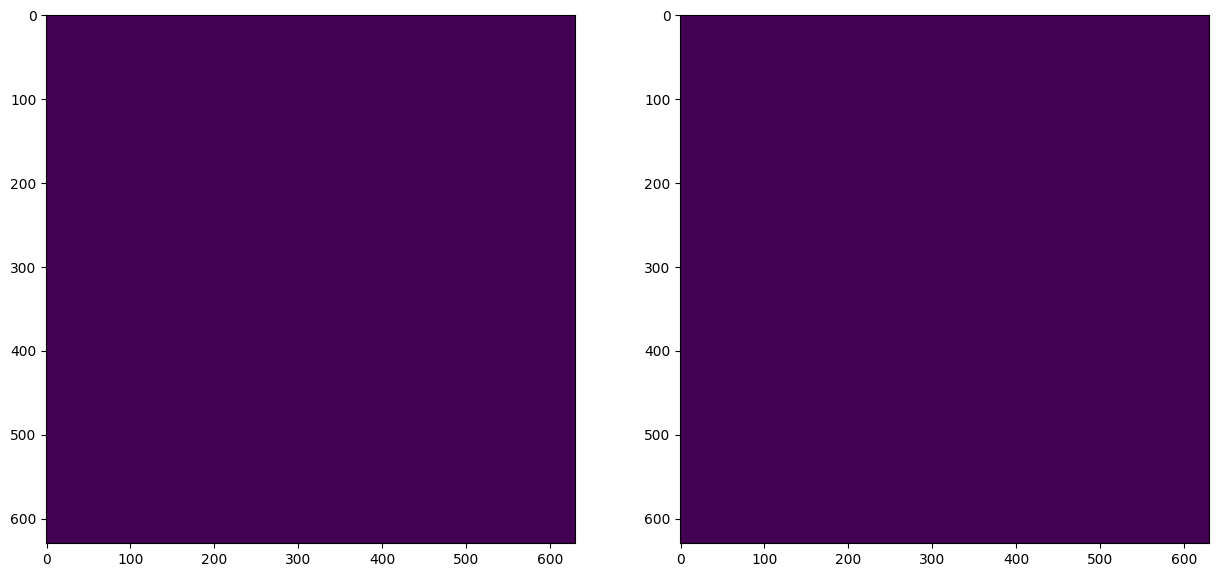

In [37]:
i = 45
plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 2, 1)
plt.imshow(inferenced_array.argmax(0)[i])

ax = plt.subplot(1, 2, 2)
plt.imshow(zeros_array[45])